In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

In [2]:
from local_libs.featureExtraction import *
from local_libs.dataAnalyzer import *
from local_libs.private_tool import *
from local_libs.dataHandler import *

In [3]:
warnings.filterwarnings('ignore')

In [4]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/src/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [5]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [6]:
for i in range(len(trialsByClasses)):
    for j in trialsByClasses[i].keys():
        for k in range(len(trialsByClasses[i][j])):
            for l in range(len(trialsByClasses[i][j][k])):
                trialsByClasses[i][j][k][l] = trialsByClasses[i][j][k][l][749:1500]

In [7]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [8]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=8, 
                                                                cutoff_high=12)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [9]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [10]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [11]:
experimentIdx = 3

In [12]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [13]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [14]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [15]:
len(CSP_passed_left_data)

25

In [16]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [17]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 751)

In [18]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 751)

In [19]:
# m = 12

# leftVarRatioDF = twoMDimensionalFeature(CSP_passed_left_data, channelNum, minTrialsNum, m)
# rightVarRatioDF = twoMDimensionalFeature(CSP_passed_right_data, channelNum, minTrialsNum, m)
# tongueVarRatioDF = twoMDimensionalFeature(CSP_passed_tongue_data, channelNum, minTrialsNum, m)
# footVarRatioDF = twoMDimensionalFeature(CSP_passed_foot_data, channelNum, minTrialsNum, m)

# VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
# labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

# VarRatioDF = VarRatioDF.reset_index()
# VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
# VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
# VarRatioDF

In [20]:
leftVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_left_data))
rightVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_right_data))
tongueVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_tongue_data))
footVarRatioDF = pd.DataFrame(MAVFeature(CSP_passed_foot_data))

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(25)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,287.003812,261.322132,284.296397,293.348113,273.064257,256.306266,199.907195,230.005569,261.322714,284.310238,...,257.057263,252.926712,227.996215,231.405366,264.170070,243.766541,190.958742,235.443135,180.513266,0
1,208.117012,201.660994,217.839666,225.856471,209.751110,205.436843,180.401336,220.866495,229.875640,254.180159,...,254.235227,233.430089,331.697442,319.001046,312.377498,359.438294,172.807874,188.766476,190.726589,0
2,264.254940,237.632752,247.652321,254.047924,270.340373,266.284051,200.864922,230.812026,251.132642,263.256779,...,275.182678,290.875637,254.612453,292.422896,319.189452,317.979634,179.810215,258.804342,249.022925,0
3,287.861005,239.299566,268.164659,301.545762,279.475907,253.173296,201.819462,255.641501,276.535490,298.397853,...,268.958108,230.693484,380.182410,351.098796,326.306876,402.282524,137.461458,207.403476,202.018338,0
4,290.805843,245.187970,280.890987,292.681375,286.247737,257.012184,182.337125,227.704380,259.609278,285.957410,...,271.216828,272.654354,274.802150,312.156518,310.481380,312.592651,171.038036,237.592760,191.826780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,279.404624,241.271321,269.031685,306.845987,314.495966,298.542375,178.895861,231.429126,267.537043,303.701273,...,370.850279,374.793205,342.832223,382.471464,422.143312,385.954756,189.254154,196.843470,171.094057,3
192,221.167198,227.367667,251.198344,246.165524,219.188975,200.044137,209.449116,262.711070,278.631233,284.824920,...,327.130540,313.509806,360.858420,367.449786,378.575787,380.327759,108.261118,171.159395,156.346852,3
193,225.598238,195.032978,209.067189,228.905607,210.357037,190.937268,140.803556,153.171790,177.020890,202.443748,...,219.926617,233.122775,242.285631,256.243269,268.401926,272.860818,138.203409,176.765441,128.933571,3
194,338.234886,278.243471,327.741569,355.281016,351.002982,331.692488,199.952644,262.774177,318.746203,347.309371,...,310.187617,281.266491,340.488285,355.589402,319.005644,345.943364,172.465491,252.583302,204.894613,3


In [21]:
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.847007,1.018961,0.897142,0.663675,0.479635,0.490838,0.708268,0.348347,0.459342,0.422566,...,-0.354156,-0.239832,-0.256437,-1.054633,-1.164592,-0.767076,-1.218506,0.944114,0.798119,-0.134486
1,-1.007545,-0.541095,-0.674979,-0.836288,-0.964162,-0.763245,0.089176,0.112399,-0.262821,-0.213745,...,0.012092,-0.296763,-0.656678,0.749742,0.310436,0.008741,0.472670,0.380058,-0.493302,0.129898
2,0.312203,0.399517,0.030279,-0.209749,0.417519,0.736820,0.738665,0.369167,0.225334,-0.022058,...,-0.179918,0.125828,0.522607,-0.591517,-0.137114,0.118367,-0.133476,0.597662,1.444462,1.638969
3,0.867158,0.443101,0.515525,0.845863,0.625846,0.413601,0.768961,1.010201,0.808695,0.720079,...,0.942793,0.000254,-0.712857,1.593367,0.850932,0.232910,1.099072,-0.718365,0.022335,0.422199
4,0.936389,0.597075,0.816583,0.648858,0.780272,0.508241,0.150616,0.288936,0.419994,0.457352,...,0.015567,0.045821,0.148547,-0.240222,0.195181,-0.021774,-0.212236,0.325059,0.857594,0.158378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.668357,0.494660,0.536035,0.963658,1.424446,1.532085,0.041394,0.385099,0.602051,0.832081,...,1.138373,2.055812,2.245329,0.943484,1.379218,1.775236,0.860353,0.891142,-0.269832,-0.378313
192,-0.700748,0.131099,0.114164,-0.384931,-0.748941,-0.896191,1.011117,1.192720,0.856822,0.433435,...,1.133435,1.173816,0.987258,1.257135,1.126267,1.074090,0.778083,-1.625794,-0.980443,-0.760062
193,-0.596578,-0.714408,-0.882503,-0.768522,-0.950345,-1.120703,-1.167608,-1.635307,-1.476598,-1.306356,...,-1.357113,-0.988900,-0.662987,-0.806001,-0.746345,-0.698972,-0.793134,-0.695309,-0.825339,-1.469688
194,2.051399,1.461430,1.924894,2.040099,2.256954,2.349334,0.709711,1.194349,1.778038,1.753031,...,1.167803,0.832012,0.325343,0.902700,0.926550,0.115409,0.275367,0.369418,1.272342,0.496655


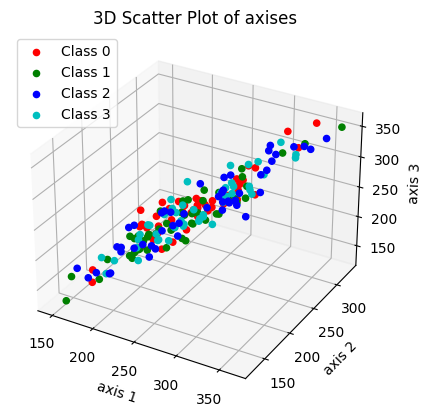

In [22]:
plotDF3D(data=VarRatioDF, num_of_classes=4)

In [23]:
# cross_validation("linear", VarRatioDF.drop(['label'], axis=1).values, labelDF)
# cross_validation("rbf", VarRatioDF.drop(['label'], axis=1).values, labelDF)

In [24]:
# n_componunts = 3
# PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
# principalDF = PCA.principalDf

In [25]:
# sum(PCA.explained_variance_ratio_())

In [26]:
# cross_validation("linear", principalDF, labelDF)
# cross_validation("rbf", principalDF, labelDF)

In [27]:
# df = pd.concat([principalDF, labelDF], axis=1)
# plotDF3D(data=df, num_of_classes=4)

In [28]:
np.save(currDir+"/test.npy", VarRatioDF)

In [29]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(x, labelDF, 3, "eigen")), labelDF], axis=1)
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [30]:
cross_validation("linear", LDA_DF.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.643076923076923
교차검증 평균:  0.643076923076923


0.643076923076923

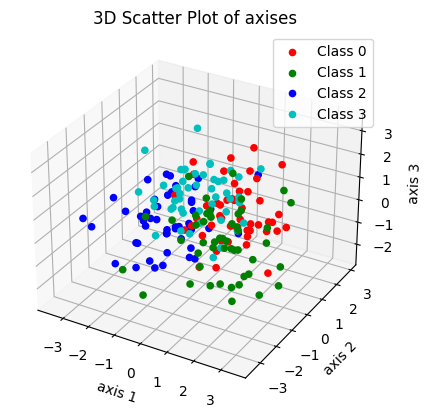

In [31]:
plotDF3D(data=LDA_DF, num_of_classes=4)

In [32]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [33]:
cross_validation("linear", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.6328205128205128
교차검증 평균:  0.6379487179487179


0.6379487179487179

In [34]:
np.save(currDir+"/test.npy", LDA_DF_Scaled)